In [1]:
from google.colab import files
uploaded = files.upload()

Saving AChE_Bioactivity_data_2.csv to AChE_Bioactivity_data_2.csv


In [2]:
!pip install pandas matplotlib seaborn rdkit scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.2/35.2 MB 22.2 MB/s eta 0:00:00


In [29]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
df = pd.read_csv("AChE_Bioactivity_data_2.csv")
print(df.shape)
df.head()

(12160, 3)


,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0


In [22]:
df.tail()

,molecule_chembl_id,canonical_smiles,standard_value
12155,CHEMBL4551344,O=C(NS(=O)(=O)c1ccc(NCC2CCOCC2)c([N+](=O)[O-])...,11.0
12156,CHEMBL3342332,CN(C)CC#Cc1ccc(OCCCc2sc(N3CCc4cccc(C(=O)Nc5nc6...,7.1
12157,CHEMBL3342191,O=C(Nc1nc2ccccc2s1)c1cccc2c1CN(c1nc(C(=O)O)c(C...,14.5
12158,CHEMBL4522930,CCC(F)(F)c1cc(N2CCC(S(C)(=O)=O)CC2)nc2sc(C(N)=...,87.0
12159,CHEMBL4802045,CC[C@@H](Nc1c(C#N)c(-c2ccc(-c3cccc(C)c3F)cc2)n...,27.0


In [24]:
# Keep only the required columns and drop rows with NaNs
df = df[['molecule_chembl_id', 'canonical_smiles', 'standard_value']].dropna()

# Drop duplicates
df.drop_duplicates(inplace=True)

# Filter out standard_value >= 1,000,000 (outliers) AND standard_value <= 0 (invalid for log)
df = df[(df['standard_value'] < 1_000_000) & (df['standard_value'] > 0)]

# Add log(IC50)
df['log_ic50'] = np.log10(df['standard_value'])

In [9]:
df = df[['molecule_chembl_id', 'canonical_smiles', 'standard_value']]

In [25]:
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,log_ic50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,2.875061
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,2.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,4.698970
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,2.477121
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,2.903090


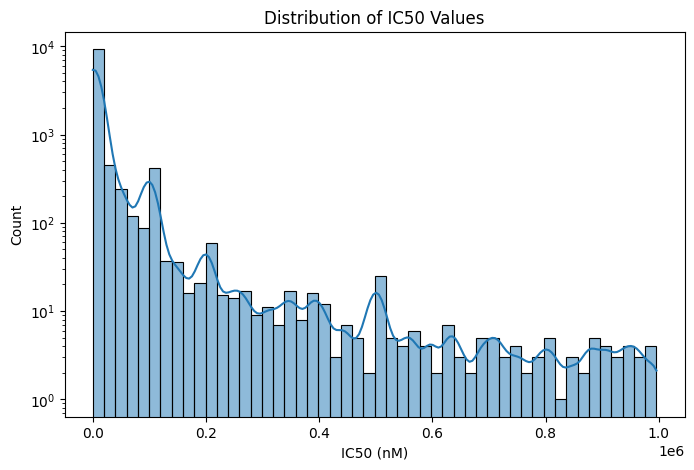

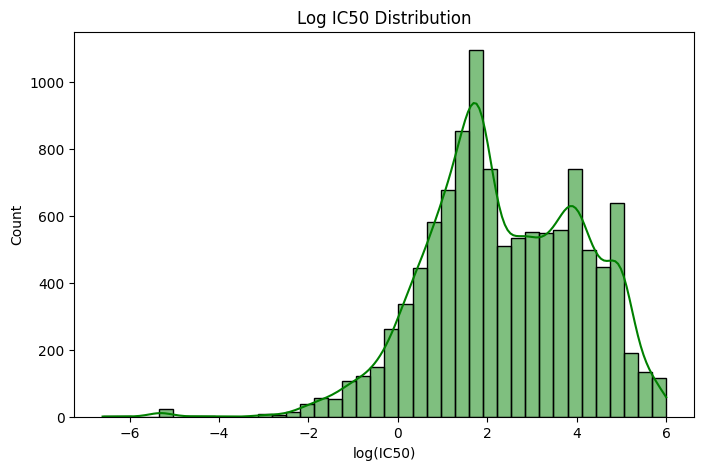

In [30]:
plt.figure(figsize=(8, 5))
sns.histplot(df['standard_value'], bins=50, kde=True)
plt.title('Distribution of IC50 Values')
plt.xlabel('IC50 (nM)')
plt.yscale('log')
plt.show()

plt.figure(figsize=(8, 5))
sns.histplot(df['log_ic50'], bins=40, kde=True, color='green')
plt.title('Log IC50 Distribution')
plt.xlabel('log(IC50)')
plt.show()

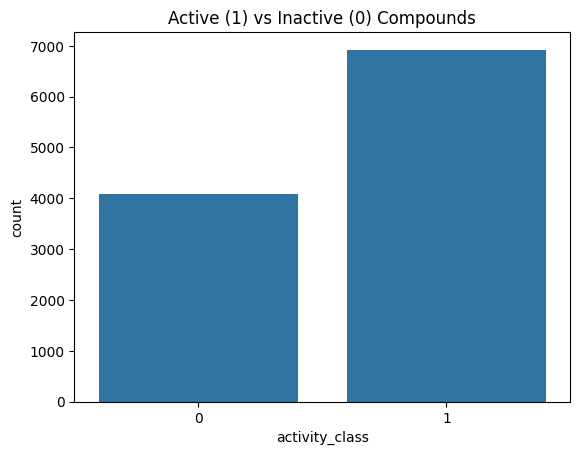

In [31]:
# Threshold at 1000 nM
df['activity_class'] = df['standard_value'].apply(lambda x: 1 if x <= 1000 else 0)

sns.countplot(x='activity_class', data=df)
plt.title('Active (1) vs Inactive (0) Compounds')
plt.show()

In [32]:
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        return {
            'MolWt': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'NumHDonors': Descriptors.NumHDonors(mol),
            'NumHAcceptors': Descriptors.NumHAcceptors(mol)
        }
    else:
        return {
            'MolWt': None,
            'LogP': None,
            'NumHDonors': None,
            'NumHAcceptors': None
        }

descriptor_df = df['canonical_smiles'].apply(compute_descriptors)
desc_df = pd.DataFrame(descriptor_df.tolist())
df = pd.concat([df, desc_df], axis=1)

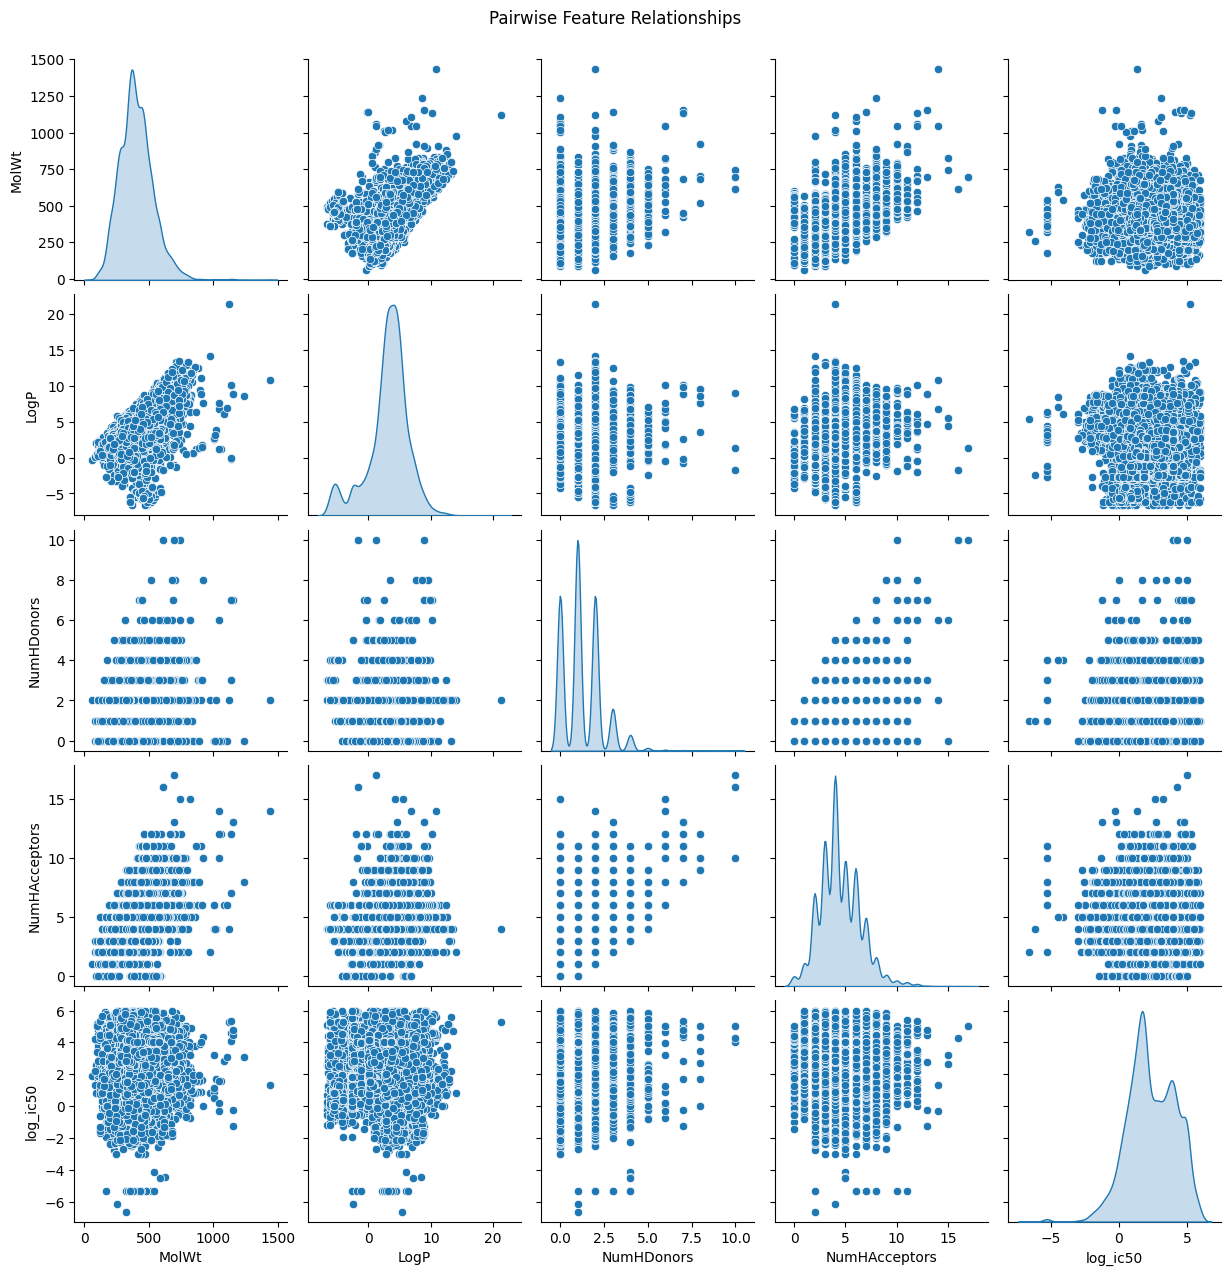

In [33]:
sns.pairplot(df[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'log_ic50']], diag_kind='kde')
plt.suptitle("Pairwise Feature Relationships", y=1.02)
plt.show()

In [34]:
print("NaNs after descriptor generation:")
print(df[['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']].isna().sum())
# Drop rows with any NaN in the descriptor columns
df.dropna(subset=['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'log_ic50'], inplace=True)

NaNs after descriptor generation:
MolWt            1070
LogP             1070
NumHDonors       1070
NumHAcceptors    1070
dtype: int64


In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

features = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors']
X = df[features]
y = df['log_ic50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

R² Score: 0.017051830999056494
RMSE: 1.7108002384852758
